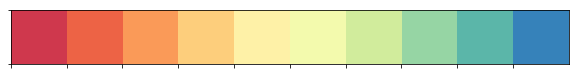

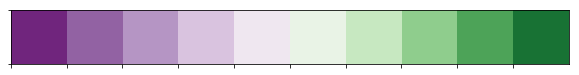

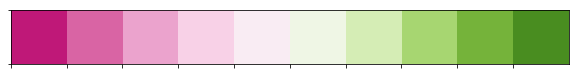

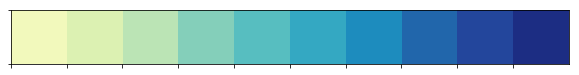

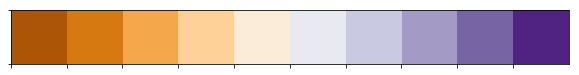

In [1]:
%matplotlib inline
import ast
from bs4 import BeautifulSoup
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import re
import requests
from scipy import stats
import seaborn as sns
sns.palplot(sns.color_palette("Spectral", 10))
sns.palplot(sns.color_palette("PRGn", 10))
sns.palplot(sns.color_palette("PiYG", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
sns.palplot(sns.color_palette("PuOr", 10))
import sqlite3
from sqlite3 import Error
import time

In [2]:
# Importing Citibike files
def import_csv_file():
    citibike_csv = []
    for month in range(1,13):
        file = "/Users/florencialeoni/Documents/flatironDS/Mod2/Blogpost_2/2018_"+str(month)+".csv"
        citibike_csv.append(file)    
    for month_1 in range(1,3):
        file_1 = "/Users/florencialeoni/Documents/flatironDS/Mod2/Blogpost_2/2019_"+str(month_1)+".csv"
        citibike_csv.append(file_1)
    return citibike_csv

In [3]:
# Create list of csv files
citibike_csv_files = import_csv_file()

In [4]:
# Iterate through citibike_csv_files to create DataFrames
list_df = []
for csv_file in citibike_csv_files:
    df = pd.read_csv(csv_file, index_col=None, header=0)
    list_df.append(df)
        
# Concatenate all DataFrames to have just one        
citibike_df = pd.concat(list_df, axis=0, ignore_index=True)

In [5]:
# Convert trip duration from seconds to minutes
citibike_df["tripduration"] = round(citibike_df.tripduration / 60, 2)

In [6]:
# Sanity check
citibike_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,15.53,2018-01-01 02:06:17.5410,2018-01-01 02:21:50.0270,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31929,Subscriber,1992,1
1,9.17,2018-01-01 12:06:18.0390,2018-01-01 12:15:28.4430,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31845,Subscriber,1969,2
2,8.50,2018-01-01 12:06:56.9780,2018-01-01 12:15:27.8100,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31708,Subscriber,1946,1
3,5.90,2018-01-01 14:53:10.1860,2018-01-01 14:59:05.0960,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,-74.038526,31697,Subscriber,1994,1
4,4.17,2018-01-01 17:34:30.1920,2018-01-01 17:38:40.9840,3183,Exchange Place,40.716247,-74.033459,3639,Harborside,40.719252,-74.034234,31861,Subscriber,1991,1


In [7]:
# Sanity check
citibike_df.tail()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
392128,6.12,2019-02-21 12:05:05.2680,2019-02-21 12:11:13.2210,3694,Jackson Square,40.71113,-74.0789,3280,Astor Place,40.719282,-74.071262,26189,Subscriber,1983,1
392129,8.28,2019-02-21 17:45:00.4510,2019-02-21 17:53:18.1580,3694,Jackson Square,40.71113,-74.0789,3679,Bergen Ave,40.722104,-74.071455,29296,Subscriber,1985,1
392130,15.98,2019-02-25 06:17:31.9310,2019-02-25 06:33:31.4950,3694,Jackson Square,40.71113,-74.0789,3183,Exchange Place,40.716247,-74.033459,29673,Subscriber,1977,1
392131,15.60,2019-02-26 06:14:45.4170,2019-02-26 06:30:21.8750,3694,Jackson Square,40.71113,-74.0789,3183,Exchange Place,40.716247,-74.033459,29672,Subscriber,1977,1
392132,13.70,2019-02-26 15:45:20.5370,2019-02-26 15:59:02.6070,3694,Jackson Square,40.71113,-74.0789,3280,Astor Place,40.719282,-74.071262,26189,Subscriber,1983,2


In [8]:
citibike_df.columns = citibike_df.columns.str.replace(' ', '_')

In [9]:
# Inspecting the data
citibike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392133 entries, 0 to 392132
Data columns (total 15 columns):
tripduration               392133 non-null float64
starttime                  392133 non-null object
stoptime                   392133 non-null object
start_station_id           392133 non-null int64
start_station_name         392133 non-null object
start_station_latitude     392133 non-null float64
start_station_longitude    392133 non-null float64
end_station_id             392133 non-null int64
end_station_name           392133 non-null object
end_station_latitude       392133 non-null float64
end_station_longitude      392133 non-null float64
bikeid                     392133 non-null int64
usertype                   392133 non-null object
birth_year                 392133 non-null int64
gender                     392133 non-null int64
dtypes: float64(5), int64(5), object(5)
memory usage: 44.9+ MB


In [10]:
# Lambda function to strip and split start and stop time string values
f = lambda x: str(x).split()[0].strip() if x != np.nan else np.nan
g = lambda x: str(x).split()[1].strip() if x != np.nan else np.nan

In [11]:
# Create a new column start date, after applying the lambda function through map
citibike_df["start_date"] = citibike_df["starttime"].map(f)

In [12]:
# Create a new column start time, applying lambda function through map
citibike_df["start_time"] = citibike_df["starttime"].map(g)

In [13]:
# Create a stop date column
citibike_df["stop_date"] = citibike_df["stoptime"].map(f)

In [14]:
# Create a stop time column
citibike_df["stop_time"] = citibike_df["stoptime"].map(g)

In [15]:
# Drop starttime and stoptime columns
citibike_df = citibike_df.drop(["starttime"], axis=1)
citibike_df = citibike_df.drop(["stoptime"], axis=1)

In [16]:
# Sanity check
citibike_df.head()

,tripduration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_date,start_time,stop_date,stop_time
0,15.53,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31929,Subscriber,1992,1,2018-01-01,02:06:17.5410,2018-01-01,02:21:50.0270
1,9.17,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31845,Subscriber,1969,2,2018-01-01,12:06:18.0390,2018-01-01,12:15:28.4430
2,8.50,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31708,Subscriber,1946,1,2018-01-01,12:06:56.9780,2018-01-01,12:15:27.8100
3,5.90,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,-74.038526,31697,Subscriber,1994,1,2018-01-01,14:53:10.1860,2018-01-01,14:59:05.0960
4,4.17,3183,Exchange Place,40.716247,-74.033459,3639,Harborside,40.719252,-74.034234,31861,Subscriber,1991,1,2018-01-01,17:34:30.1920,2018-01-01,17:38:40.9840


In [17]:
# Check for null values
citibike_df.isnull().any()

tripduration               False
start_station_id           False
start_station_name         False
start_station_latitude     False
start_station_longitude    False
end_station_id             False
end_station_name           False
end_station_latitude       False
end_station_longitude      False
bikeid                     False
usertype                   False
birth_year                 False
gender                     False
start_date                 False
start_time                 False
stop_date                  False
stop_time                  False
dtype: bool

In [18]:
# Trial to change date column to datetime objects
citibike_df["start_date"] = pd.to_datetime(citibike_df["start_date"], yearfirst = True, errors = "coerce")

In [19]:
# Change date and time columns to datetime objects
citibike_df["stop_date"] = pd.to_datetime(citibike_df["stop_date"], yearfirst = True, errors = "coerce")
citibike_df["start_time"] = pd.to_datetime(citibike_df["start_time"],errors = "coerce")
citibike_df["stop_time"] = pd.to_datetime(citibike_df["stop_time"], errors = "coerce")

In [20]:
# Create day of the week column
citibike_df["dow_start"] = citibike_df["start_date"].dt.dayofweek
citibike_df["dow_stop"] = citibike_df["stop_date"].dt.dayofweek

In [21]:
# Sanity check
citibike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392133 entries, 0 to 392132
Data columns (total 19 columns):
tripduration               392133 non-null float64
start_station_id           392133 non-null int64
start_station_name         392133 non-null object
start_station_latitude     392133 non-null float64
start_station_longitude    392133 non-null float64
end_station_id             392133 non-null int64
end_station_name           392133 non-null object
end_station_latitude       392133 non-null float64
end_station_longitude      392133 non-null float64
bikeid                     392133 non-null int64
usertype                   392133 non-null object
birth_year                 392133 non-null int64
gender                     392133 non-null int64
start_date                 392133 non-null datetime64[ns]
start_time                 392133 non-null datetime64[ns]
stop_date                  392133 non-null datetime64[ns]
stop_time                  392133 non-null datetime64[ns]
dow_sta

In [23]:
citibike_df = citibike_df[~citibike_df.usertype.str.contains("Customer")]

In [24]:
trips_json_df = citibike_df[["start_station_latitude", "start_station_longitude", "start_time", "start_date",
                             "stop_time", "stop_date", "end_station_latitude", "end_station_longitude"]].copy()


In [27]:
citibike_json = trips_json_df.to_json(orient = "records")

In [28]:
import json
data = citibike_json
with open('citibike.json', 'w') as outfile:
    json.dump(data, outfile)

In [114]:
# Function to create a new SQLite3 Database
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        conn.close()

In [115]:
# Use create_connection function to create Database
create_connection("/Users/florencialeoni/Documents/flatironDS/Mod2/Blogpost_2/citibikes.db")

In [116]:
# Create a connection object using the connect function 
# To establish a connection with "citibikes.db"
connection = sqlite3.connect("citibikes.db")
# Create a cursor object by calling the cursor method
cursor = connection.cursor()

In [118]:
# Write records stored in the citibike DataFrame to a SQL database
citibike_df.to_sql("citibikes", con = connection)

In [119]:
pd.read_sql_query('''SELECT * FROM citibikes''', connection)

,index,tripduration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,start_date,start_time,stop_date,stop_time,dow_start,dow_stop
0,0,15.53,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31929,Subscriber,1992,2018-01-01 00:00:00,2019-04-13 02:06:17.541000,2018-01-01 00:00:00,2019-04-13 02:21:50.027000,0,0
1,1,9.17,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31845,Subscriber,1969,2018-01-01 00:00:00,2019-04-13 12:06:18.039000,2018-01-01 00:00:00,2019-04-13 12:15:28.443000,0,0
2,2,8.50,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31708,Subscriber,1946,2018-01-01 00:00:00,2019-04-13 12:06:56.978000,2018-01-01 00:00:00,2019-04-13 12:15:27.810000,0,0
3,3,5.90,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,-74.038526,31697,Subscriber,1994,2018-01-01 00:00:00,2019-04-13 14:53:10.186000,2018-01-01 00:00:00,2019-04-13 14:59:05.096000,0,0
4,4,4.17,3183,Exchange Place,40.716247,-74.033459,3639,Harborside,40.719252,-74.034234,31861,Subscriber,1991,2018-01-01 00:00:00,2019-04-13 17:34:30.192000,2018-01-01 00:00:00,2019-04-13 17:38:40.984000,0,0
5,5,10.22,3183,Exchange Place,40.716247,-74.033459,3203,Hamilton Park,40.727596,-74.044247,31859,Subscriber,1982,2018-01-01 00:00:00,2019-04-13 22:05:05.874000,2018-01-01 00:00:00,2019-04-13 22:15:19.419000,0,0
6,6,4.83,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,-74.038526,31694,Subscriber,1958,2018-01-02 00:00:00,2019-04-13 12:13:51.794000,2018-01-02 00:00:00,2019-04-13 12:18:42.107000,1,1
7,7,6.35,3183,Exchange Place,40.716247,-74.033459,3205,JC Medical Center,40.716540,-74.049638,31754,Subscriber,1989,2018-01-02 00:00:00,2019-04-13 12:50:03.343000,2018-01-02 00:00:00,2019-04-13 12:56:24.644000,1,1
8,8,5.30,3183,Exchange Place,40.716247,-74.033459,3275,Columbus Drive,40.718355,-74.038914,31816,Subscriber,1960,2018-01-02 00:00:00,2019-04-13 13:55:58.243000,2018-01-02 00:00:00,2019-04-13 14:01:16.881000,1,1
9,9,30.87,3183,Exchange Place,40.716247,-74.033459,3281,Leonard Gordon Park,40.745910,-74.057271,31754,Subscriber,1976,2018-01-02 00:00:00,2019-04-13 16:55:29.639000,2018-01-02 00:00:00,2019-04-13 17:26:22.305000,1,1


In [120]:
pd.read_sql_query('''SELECT bikeid, COUNT(bikeid) 
                    FROM citibikes GROUP BY bikeid 
                    HAVING COUNT(bikeid) > 600 
                    ORDER BY COUNT(bikeid) DESC''', connection)

,bikeid,COUNT(bikeid)
0,29586,922
1,26155,918
2,29598,906
3,26288,904
4,29588,902
5,29595,892
6,29602,891
7,29673,863
8,26243,855
9,29231,840


In [121]:
pd.read_sql_query('''SELECT * FROM citibikes WHERE bikeid = 29586''', connection)

,index,tripduration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,start_date,start_time,stop_date,stop_time,dow_start,dow_stop
0,643,3.33,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,-74.038526,29586,Subscriber,1992,2018-01-27 00:00:00,2019-04-13 21:01:22.156000,2018-01-27 00:00:00,2019-04-13 21:04:42.810000,5,5
1,1843,3.27,3186,Grove St PATH,40.719586,-74.043117,3279,Dixon Mills,40.721630,-74.049968,29586,Subscriber,1973,2018-01-12 00:00:00,2019-04-13 08:47:06.864000,2018-01-12 00:00:00,2019-04-13 08:50:23.471000,4,4
2,1848,3.13,3186,Grove St PATH,40.719586,-74.043117,3279,Dixon Mills,40.721630,-74.049968,29586,Subscriber,1967,2018-01-12 00:00:00,2019-04-13 10:59:39.736000,2018-01-12 00:00:00,2019-04-13 11:02:47.944000,4,4
3,1894,5.00,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,-74.050389,29586,Subscriber,1988,2018-01-12 00:00:00,2019-04-13 20:44:54.787000,2018-01-12 00:00:00,2019-04-13 20:49:55.594000,4,4
4,1930,2.42,3186,Grove St PATH,40.719586,-74.043117,3211,Newark Ave,40.721525,-74.046305,29586,Subscriber,1981,2018-01-14 00:00:00,2019-04-13 12:39:20.575000,2018-01-14 00:00:00,2019-04-13 12:41:46.233000,6,6
5,3248,4.28,3187,Warren St,40.721124,-74.038051,3203,Hamilton Park,40.727596,-74.044247,29586,Subscriber,1976,2018-01-16 00:00:00,2019-04-13 13:37:18.363000,2018-01-16 00:00:00,2019-04-13 13:41:35.649000,1,1
6,3581,7.55,3192,Liberty Light Rail,40.711242,-74.055701,3213,Van Vorst Park,40.718489,-74.047727,29586,Subscriber,1989,2018-01-16 00:00:00,2019-04-13 16:58:31.785000,2018-01-16 00:00:00,2019-04-13 17:06:05.328000,1,1
7,3770,6.07,3193,Lincoln Park,40.724605,-74.078406,3195,Sip Ave,40.730743,-74.063784,29586,Subscriber,1983,2018-01-20 00:00:00,2019-04-13 22:19:29.936000,2018-01-20 00:00:00,2019-04-13 22:25:34.483000,5,5
8,3955,3.00,3194,McGinley Square,40.725340,-74.067622,3195,Sip Ave,40.730743,-74.063784,29586,Subscriber,1986,2018-01-19 00:00:00,2019-04-13 09:45:09.737000,2018-01-19 00:00:00,2019-04-13 09:48:10.561000,4,4
9,3968,5.80,3194,McGinley Square,40.725340,-74.067622,3193,Lincoln Park,40.724605,-74.078406,29586,Subscriber,1990,2018-01-20 00:00:00,2019-04-13 11:46:34.759000,2018-01-20 00:00:00,2019-04-13 11:52:22.786000,5,5


In [122]:
pd.read_sql_query('''SELECT SUM(tripduration) FROM citibikes WHERE bikeid = 29586''', connection)

,SUM(tripduration)
0,6771.17


In [125]:
pd.read_sql_query('''SELECT birth_year, COUNT(birth_year), AVG(tripduration)
                    FROM citibike GROUP BY birth_year  
                    ORDER BY COUNT(birth_year) DESC''', connection)

,birth_year,COUNT(birth_year),AVG(tripduration)
0,1988,23381,8.594193
1,1986,20420,8.204633
2,1989,19124,6.835271
3,1987,18465,8.039161
4,1990,16470,7.803457
5,1985,16209,8.853418
6,1984,15492,8.038085
7,1983,15491,8.814712
8,1981,14908,7.699203
9,1991,14774,9.447064


In [126]:
pd.read_sql_query('''SELECT birth_year, COUNT(birth_year), AVG(tripduration)
                    FROM citibike GROUP BY birth_year  
                    ORDER BY AVG(tripduration) DESC''', connection)

,birth_year,COUNT(birth_year),AVG(tripduration)
0,2001,7,500.794286
1,1939,2,65.945000
2,1900,2,41.785000
3,2000,150,37.841200
4,1998,482,31.709627
5,1999,34,29.962941
6,1948,10,21.953000
7,1949,555,16.466342
8,1961,1731,15.743934
9,1942,9,15.448889
